# Cross checks

Johann Brehmer, Kyle Cranmer, Marco Farina, Felix Kling, Duccio Pappadopulo, Josh Ruderman 2018

In [23]:
from __future__ import absolute_import, division, print_function, unicode_literals

import math
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.core import MadMiner
from madminer.delphes import DelphesProcessor
from madminer.sampling import SampleAugmenter
from madminer.utils.particle import MadMinerParticle
from madminer.sampling import multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas

In [2]:
base_dir = '/Users/johannbrehmer/work/projects/madminer/diboson_mining/'
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/'

In [15]:
sample_dir = base_dir + 'data/samples/wgamma_check/'
card_dir = base_dir + 'cards/wgamma_check/'
ufo_model_dir = card_dir + 'SMWgamma_UFO'
run_card_dir = card_dir + 'run_cards/'
mg_process_dir = base_dir + 'data/mg_processes/wgamma_check/'
log_dir = base_dir + 'logs/wgamma_check/'
temp_dir = base_dir + 'data/temp'
delphes_dir = mg_dir + 'Delphes'

## Load setup

In [4]:
mm = MadMiner(debug=False)

mm.load(sample_dir + 'setup.h5')

12:48  
12:48  ------------------------------------------------------------
12:48  |                                                          |
12:48  |  MadMiner v0.1.0                                         |
12:48  |                                                          |
12:48  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
12:48  |                                                          |
12:48  ------------------------------------------------------------
12:48  
12:48  Found 2 parameters:
12:48     cWWW (LHA: dim6 1, maximal power in squared ME: (2,), range: (-0.02, 0.02))
12:48     cWWWtilde (LHA: dim6 2, maximal power in squared ME: (2,), range: (-0.02, 0.02))
12:48  Found 6 benchmarks:
12:48     sm: cWWW = 0.00e+00, cWWWtilde = 0.00e+00
12:48     morphing_basis_vector_1: cWWW = -6.07e-03, cWWWtilde = -1.84e-02
12:48     morphing_basis_vector_2: cWWW = 1.00e-02, cWWWtilde = 1.70e-02
12:48     morphing_basis_vector_3: cWWW = -1.99e-02, cWWWtilde = 1.87e-02
12:

## Run MG

In [5]:
run_card_filenames = [run_card_dir + 'run_card.dat']

In [6]:
mm.run_multiple(
    mg_directory=mg_dir,
    proc_card_file=card_dir + 'proc_card_mg5.dat',
    param_card_template_file=card_dir + 'param_card.dat',
    pythia8_card_file=card_dir + 'pythia8_card.dat',
    run_card_files=run_card_filenames,
    mg_process_directory=mg_process_dir,
    ufo_model_directory=ufo_model_dir,
    temp_directory=temp_dir,
    sample_benchmarks=['sm'],
    is_background=False,
    only_prepare_script=False,
    initial_command='source activate python2',
    log_directory=log_dir
)

12:49  Generating MadGraph process folder from /Users/johannbrehmer/work/projects/madminer/diboson_mining/cards/wgamma_check/proc_card_mg5.dat at /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/mg_processes/wgamma_check/
12:49  Run 0
12:49    Sampling from benchmark: sm
12:49    Original run card:       /Users/johannbrehmer/work/projects/madminer/diboson_mining/cards/wgamma_check/run_cards/run_card.dat
12:49    Original Pythia8 card:   /Users/johannbrehmer/work/projects/madminer/diboson_mining/cards/wgamma_check/run_cards/run_card.dat
12:49    Copied run card:         /madminer/cards/run_card_0.dat
12:49    Copied Pythia8 card:     /madminer/cards/pythia8_card_0.dat
12:49    Param card:              /madminer/cards/param_card_0.dat
12:49    Reweight card:           /madminer/cards/reweight_card_0.dat
12:49    Log file:                run_0.log
12:49  Creating param and reweight cards in /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/mg_processes/wgamma_

## Define observables

In [7]:
def calculate_mt(leptons, photons, jets, met):
    # Particles
    if len(leptons) < 1:
        raise RuntimeError()
    
    l = leptons[0]
    
    # Transverse mass and Delta
    cos_delta_phi = np.cos(l.phi() - met.phi())
    mt = (2 * l.pt * met.pt * (1. - cos_delta_phi))**0.5
    
    return mt

In [8]:
def calculate_phi(leptons, photons, jets, met):
    # Parameters
    mw = 80.4
    
    # Particles
    if len(leptons) < 1 or len(photons) < 1:
        raise RuntimeError()
    
    l = leptons[0]
    a = photons[0]
    
    # Transverse mass and Delta
    mt = calculate_mt(leptons, photons, jets, met)
    deltasq = 0.
    if met.pt > 0. and l.pt > 0.:
        deltasq = (mw**2 - mt**2) / (2. * met.pt * l.pt)
    
    # v reconstruction, "normal" case
    if deltasq > 0.:
        # Two solutions
        temp = np.log(1 + deltasq**0.5 * (2 + deltasq)**0.5 + deltasq)
        eta_v_plus = l.eta + temp
        eta_v_minus = l.eta - temp
        
        # Randomly select one of them
        dice = np.random.rand()
        if dice > 0.5:
            eta_v = eta_v_plus
        else:
            eta_v = eta_v_minus
            
    # v reconstruction, "other" case
    else:
        eta_v = l.eta
        
    # v particle
    v = MadMinerParticle()
    v.setptetaphim(met.pt, eta_v, met.phi(), 0.)
    
    # W and Wgamma reconstruction
    w = l + v
    vv = w + a
    
    # Boost into VV frame
    v_ = v.boost(vv.boostvector)
    l_ = l.boost(vv.boostvector)
    a_ = a.boost(vv.boostvector)
    w_ = w.boost(vv.boostvector)
    r_ = vv # vv.boost(vv.boostvector)

    # Calculate axes of "special frame" (1708.07823)
    z_ = w_.vector.unit()
    x_ = (r_.vector - z_ * r_.vector.dot(z_)).unit()
    y_ = z_.cross(x_)
    
    # Calculate x and y components of lepton wrt special x_, y_, z_ system
    lx_ = l_.vector.dot(x_)
    ly_ = l_.vector.dot(y_)
    
    # Calculate phi
    phi = math.atan2(ly_, lx_)
    
    return phi
    

In [9]:
def setup_observables(delphesprocessor):
    delphesprocessor.reset_observables()
    delphesprocessor.reset_cuts()
        
    # Default observables
    delphesprocessor.add_default_observables(
        n_leptons_max=1,
        n_photons_max=1,
        n_jets_max=1,
        include_charge=False,
        include_numbers=False,
        include_met=True
    )

    # Correlations with MET
    for s1, i1 in [('l', 0), ('a', 0)]:
        delphesprocessor.add_observable(
            'deltaphi_{}{}_met'.format(s1, i1+1),
            '{}[{}].phi() - met.phi()'.format(s1, i1),
            required=True
        )

    # Reconstructed W
    delphesprocessor.add_observable(
        'm_l1_met',
        '(l[0] + met).m',
        required=True
    )
    delphesprocessor.add_observable(
        'pt_l1_met',
        '(l[0] + met).pt',
        required=True
    )

    # Selected correlations between particles
    for s1, i1, s2, i2 in [('l', 0, 'a', 0)]:
        delphesprocessor.add_observable(
            'm_{}{}_{}{}'.format(s1, i1+1, s2, i2+1),
            '({}[{}] + {}[{}]).m'.format(s1, i1, s2, i2),
            required=True
        )
        delphesprocessor.add_observable(
            'deltaeta_{}{}_{}{}'.format(s1, i1+1, s2, i2+1),
            '{}[{}].eta - {}[{}].eta'.format(s1, i1, s2, i2),
            required=True
        )
        delphesprocessor.add_observable(
            'deltaphi_{}{}_{}{}'.format(s1, i1+1, s2, i2+1),
            '{}[{}].phi() - {}[{}].phi()'.format(s1, i1, s2, i2),
            required=True
        )

    # Wgamma system
    delphesprocessor.add_observable(
        'm_a1_l1_met',
        '(a[0] + l[0] + met).m',
        required=True
    )
    delphesprocessor.add_observable(
        'pt_a1_l1_met',
        '(a[0] + l[0] + met).pt',
        required=True
    )
    
    # mT(W)
    delphesprocessor.add_observable_from_function(
        'mt',
        calculate_mt,
        required=True
    )
    
    # Resurection phi
    delphesprocessor.add_observable_from_function(
        'phi_resurrection',
        calculate_phi,
        required=True
    )



In [10]:
def setup_cuts(delphesprocessor):
    delphesprocessor.cuts = []
    delphesprocessor.cuts_default_pass = []
    
    delphesprocessor.add_cut(
        'pt_a1 >= 300.'
    )
    delphesprocessor.add_cut(
        'pt_l1 >= 80.'
    )
    delphesprocessor.add_cut(
        'et_miss >= 80.'
    )
    delphesprocessor.add_cut(
        '(deltaphi_l1_a1**2 + deltaeta_l1_a1**2)**0.5 >= 3.'
    )
    delphesprocessor.add_cut(
        'eta_l1**2 < 2.4**2'
    )
        

## Run Delphes

In [ ]:
# Load setup
dp = DelphesProcessor(sample_dir + 'setup.h5', debug=False)

# Load events
for benchmark in ['sm']:
    dp.add_hepmc_sample(
        mg_process_dir + 'Events/run_01/tag_1_pythia8_events.hepmc.gz',
        sampled_from_benchmark=benchmark
    )

# Run Delphes
dp.run_delphes(
    delphes_directory=delphes_dir,
    delphes_card=card_dir + 'delphes_card.dat',
    log_file=log_dir + '/delphes.log',
    initial_command='source activate python2',
)

# Analysis (with tight cuts)
setup_observables(dp)
setup_cuts(dp)

dp.analyse_delphes_samples(delete_delphes_files=False)

dp.save(sample_dir + 'samples_tight.h5')


In [20]:
# Tight analysis
setup_observables(dp)
setup_cuts(dp)

dp.analyse_delphes_samples(delete_delphes_files=False)

dp.save(sample_dir + 'samples_tight.h5')



13:14  Analysing Delphes sample /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/mg_processes/wgamma_check/Events/run_01/tag_1_pythia8_events_delphes.root
13:15    27257 / 50000 events pass everything


## Sampling

In [21]:
sa = SampleAugmenter(sample_dir + 'samples_tight.h5', debug=False)

13:19  Loading data from /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/samples/wgamma_check/samples_tight.h5
13:19  Found 2 parameters:
13:19     cWWW (LHA: dim6 1, maximal power in squared ME: (2,), range: (-0.02, 0.02))
13:19     cWWWtilde (LHA: dim6 2, maximal power in squared ME: (2,), range: (-0.02, 0.02))
13:19  Found 6 benchmarks:
13:19     sm: cWWW = 0.00e+00, cWWWtilde = 0.00e+00
13:19     morphing_basis_vector_1: cWWW = -6.07e-03, cWWWtilde = -1.84e-02
13:19     morphing_basis_vector_2: cWWW = 1.00e-02, cWWWtilde = 1.70e-02
13:19     morphing_basis_vector_3: cWWW = -1.99e-02, cWWWtilde = 1.87e-02
13:19     morphing_basis_vector_4: cWWW = 1.97e-02, cWWWtilde = -1.53e-02
13:19     morphing_basis_vector_5: cWWW = -1.65e-02, cWWWtilde = -6.33e-03
13:19  Found 27 observables: et_miss, phi_miss, e_visible, eta_visible, e_l1, pt_l1, eta_l1, phi_l1, e_a1, pt_a1, eta_a1, phi_a1, e_j1, pt_j1, eta_j1, phi_j1, deltaphi_l1_met, deltaphi_a1_met, m_l1_met, pt_l1_met, m_l1_

In [27]:
x_unweighted, _ = sa.extract_samples_train_plain(
    theta=constant_morphing_theta([0.,0.]),
    n_samples=100000,
    folder=None,
    filename=None,
    test_split=None
)

13:20  Extracting plain training sample. Sampling according to ('theta', array([0., 0.]))
13:20  Effective number of samples: 27261.951977624296


In [28]:
x_weighted, weights = sa.extract_raw_data(theta=[0.,0.])

## Look at distributions

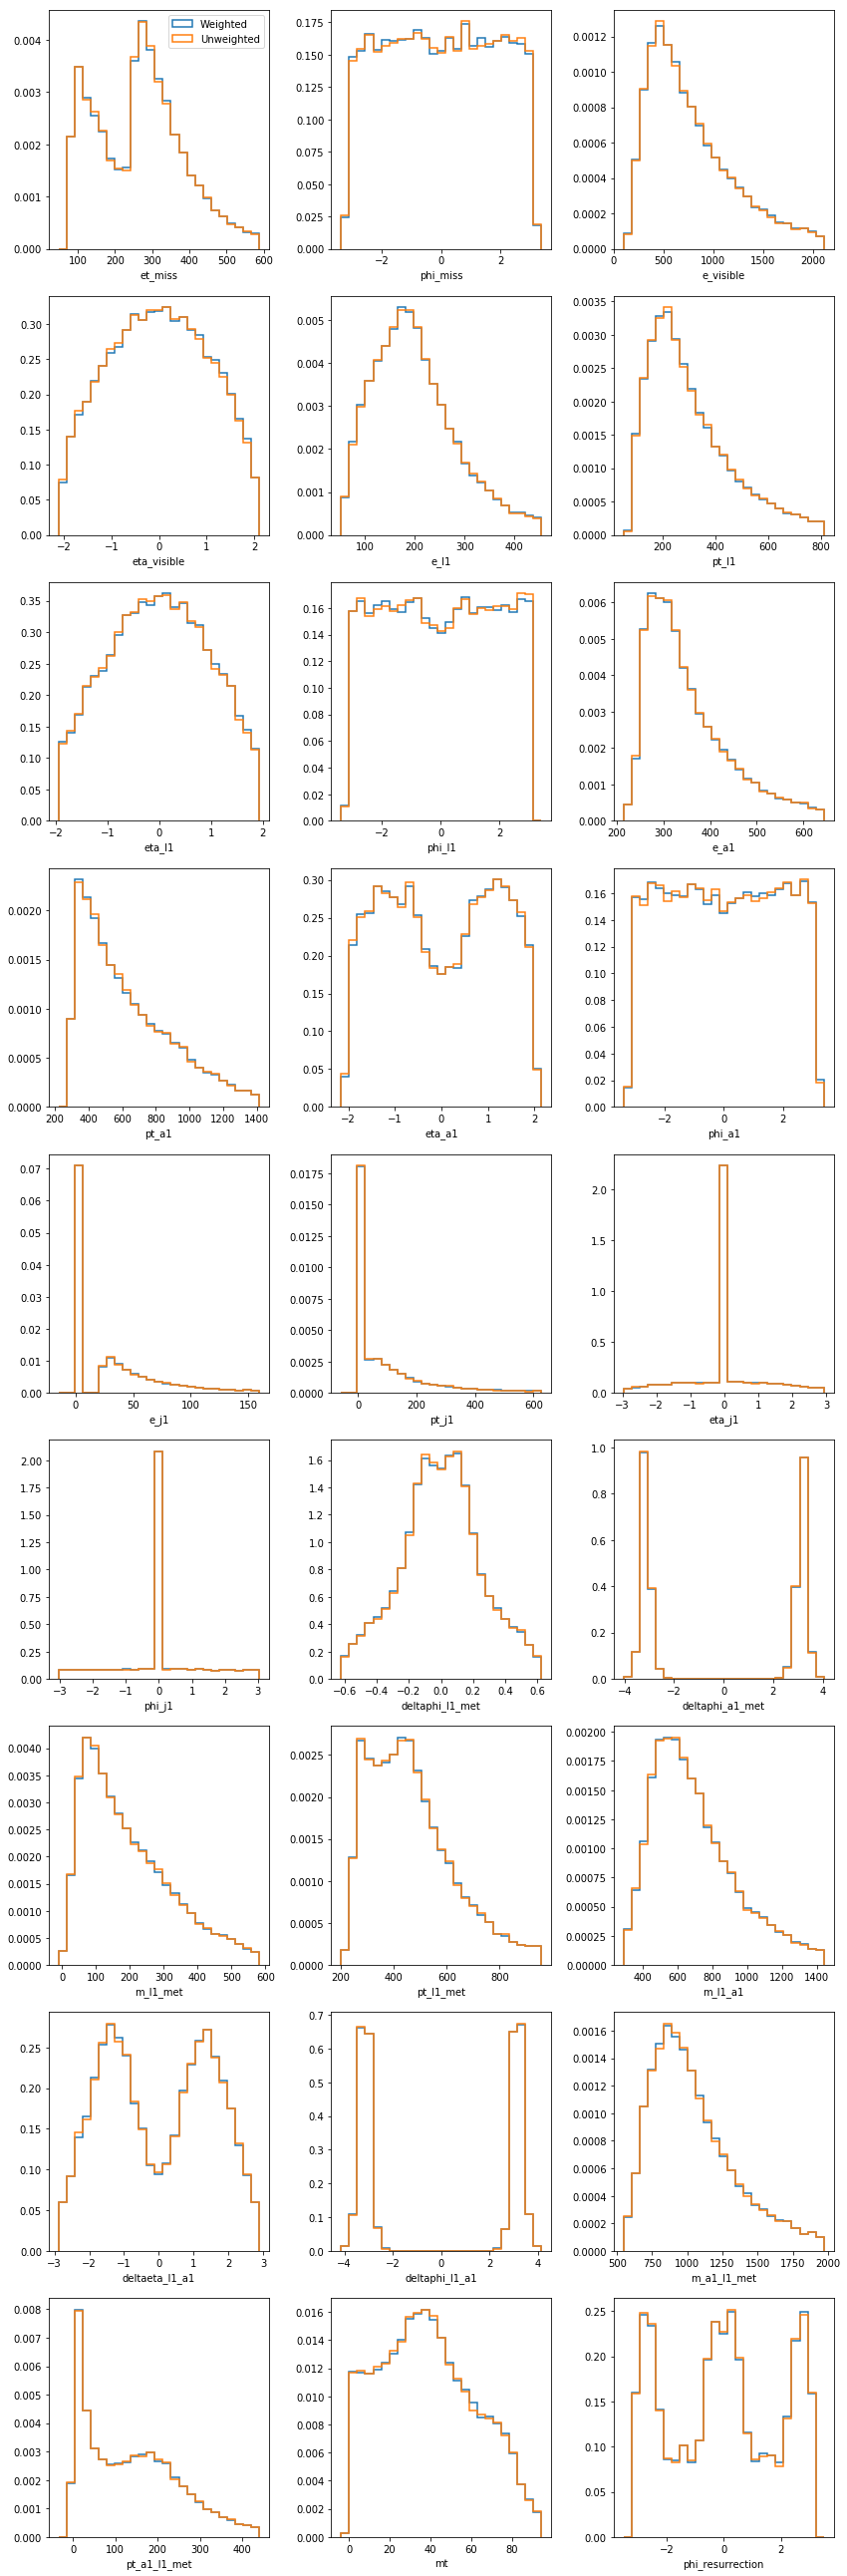

In [30]:
bins = 25
n_observables = x_unweighted.shape[1]
n_cols = 3
n_rows = (n_observables + n_cols - 1) // n_cols
labels = sa.observables.keys()

plt.figure(figsize=(4. * n_cols, 4. * n_rows))

for i, label in enumerate(labels):
    xmin = np.percentile(x_unweighted[:,i], 5.)
    xmax = np.percentile(x_unweighted[:,i], 95.)
    xwidth = xmax - xmin
    xmin -= xwidth * 0.1
    xmax += xwidth * 0.1
    x_range = (xmin, xmax)
    
    ax = plt.subplot(n_rows, n_cols, i+1)
       
    plt.hist(x_weighted[:,i], weights=weights, histtype='step', range=x_range, bins=bins, lw=1.5, label=r'Weighted', density=True)
    plt.hist(x_unweighted[:,i], histtype='step', range=x_range, bins=bins, lw=1.5, label=r'Unweighted', density=True)
    
    if i == 0:
        plt.legend()
        
    plt.xlabel(label)
    
plt.tight_layout()
plt.show()